<a href="https://colab.research.google.com/github/UygarUsta/Codes/blob/main/BCDD_Retinanet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -L "https://public.roboflow.com/ds/GVAJkKQvLc?key=GCSaKIEdio" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [2]:
from random import shuffle,seed


In [6]:
!git clone https://github.com/pytorch/vision.git


Cloning into 'vision'...
remote: Enumerating objects: 71554, done.
remote: Counting objects: 100% (6616/6616), done.
remote: Compressing objects: 100% (529/529), done.
remote: Total 71554 (delta 6106), reused 6488 (delta 6052), pack-reused 64938
Receiving objects: 100% (71554/71554), 137.17 MiB | 22.32 MiB/s, done.
Resolving deltas: 100% (59226/59226), done.


In [7]:
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

In [ ]:
!pip install albumentations==0.4.6

In [2]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
from glob import glob
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV

# matplotlib for visualization
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm

In [27]:
 with open("/content/classes.txt","r") as f: clx = f.read().split()
clx

['RBC', 'WBC', 'Platelets']

In [3]:
train_set = glob("/content/train/*.xml")
valid_set = glob("/content/valid/*.xml")

In [4]:
import xml.etree.ElementTree as ET
from xml.dom.minidom import parse
import cv2

In [5]:
class Parser(torch.utils.data.Dataset):
  def __init__(self,path,transforms = None):
    self.path = path
    self.transforms = transforms
    with open("/content/classes.txt","r") as f: self.classes= f.read().split()

  def __len__(self):
    return len(self.path)

  def __getitem__(self,ix):
    img_name = self.path[ix].replace(".xml",".jpg")
    xml_name = self.path[ix]
    img = cv2.imread(img_name)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    #img_res = cv2.resize(img_rgb, (416, 416), cv2.INTER_AREA)
    img_res = img_rgb
    img_res /= 255.0

    boxes = []
    labels = []

    wt = img.shape[1]
    ht = img.shape[0]

    dom = parse(xml_name)
    root = dom.documentElement
    filename = root.getElementsByTagName("filename")[0].childNodes[0].data
    for items in root.getElementsByTagName("object") :
      name = items.getElementsByTagName("name")[0].childNodes[0].data
      xmin = int(items.getElementsByTagName("xmin")[0].childNodes[0].data) 
      ymin = int(items.getElementsByTagName("ymin")[0].childNodes[0].data) 
      xmax = int(items.getElementsByTagName("xmax")[0].childNodes[0].data)  
      ymax = int(items.getElementsByTagName("ymax")[0].childNodes[0].data)

      if xmin/wt >1:
        xmin = 415

      if xmax/wt >1:
        xmax = 415
        
      if ymin/ht >1:
        ymin = 415
      if ymax/ht >1:
        ymax = 415
      if xmax <= xmin:
        xmin = xmin - (xmax-xmin) - 1
      if ymax <= ymin:
        ymin = ymin - (ymax-ymin) - 1
        
      labels.append(self.classes.index(name)) 

      boxes.append([xmin,ymin,xmax,ymax])


    boxes = torch.as_tensor(boxes,dtype = torch.float32)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["area"] = area
    target["iscrowd"] = iscrowd
    image_id = torch.tensor([ix])
    target["image_id"] = image_id

    if self.transforms:


      sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])

    return img_res,target


In [6]:
from torchvision.models.detection.retinanet import RetinaNet
from torchvision.models.detection.anchor_utils import AnchorGenerator

In [7]:
def get_object_detection_model(num_classes):


  backbone = torchvision.models.mobilenet_v3_large(pretrained=True).features
  backbone.out_channels = 960
  anchor_generator = AnchorGenerator(
            sizes=((4,8,16,32,64),),
            aspect_ratios=((0.5, 1.0, 2.0),))

  model = RetinaNet(backbone,
                  num_classes=num_classes,
                  anchor_generator=anchor_generator)
    

  return model

In [8]:
def get_transform(train):

    
  if train:
    return A.Compose([
                            A.HorizontalFlip(0.5),
                            A.RandomBrightnessContrast(p=0.2),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                           ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  else:
    return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [9]:
train_dataset = Parser(train_set,transforms=get_transform(train = True))
val_dataset = Parser(valid_set,transforms = get_transform(train = False))

train_dl = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

val_dl = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 4
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [11]:
num_epochs = 8

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_dl, device=device)
    torch.save(model.state_dict(), "./retinanetbcdd.pth")

Epoch: [0]  [  0/765]  eta: 0:06:19  lr: 0.000012  loss: 3.7078 (3.7078)  classification: 1.1112 (1.1112)  bbox_regression: 2.5966 (2.5966)  time: 0.4959  data: 0.0305  max mem: 1226
Epoch: [0]  [ 10/765]  eta: 0:05:09  lr: 0.000077  loss: 4.1717 (4.1574)  classification: 1.1134 (1.1035)  bbox_regression: 3.0469 (3.0539)  time: 0.4101  data: 0.0283  max mem: 1556
Epoch: [0]  [ 20/765]  eta: 0:04:52  lr: 0.000142  loss: 3.3794 (3.6413)  classification: 1.0672 (1.0710)  bbox_regression: 2.3662 (2.5704)  time: 0.3876  data: 0.0207  max mem: 1556
Epoch: [0]  [ 30/765]  eta: 0:04:44  lr: 0.000208  loss: 2.8862 (3.3729)  classification: 0.9631 (0.9928)  bbox_regression: 1.8897 (2.3800)  time: 0.3738  data: 0.0134  max mem: 1556
Epoch: [0]  [ 40/765]  eta: 0:04:38  lr: 0.000273  loss: 2.4710 (3.0989)  classification: 0.6523 (0.8702)  bbox_regression: 1.8216 (2.2286)  time: 0.3756  data: 0.0152  max mem: 1556
Epoch: [0]  [ 50/765]  eta: 0:04:33  lr: 0.000338  loss: 2.1222 (2.8694)  classificat

In [15]:
test_set = glob("/content/test/*.xml")

In [16]:
test_dataset = Parser(test_set,transforms = get_transform(train = False))

In [35]:
im,target = test_dataset[10]

In [ ]:
im,target 

In [20]:
def torch_to_pil(img):

  return torchtrans.ToPILImage()(img).convert('RGB')


In [38]:
from time import time

In [39]:
model.eval()

with torch.no_grad():
  f1 = time()
  prediction = model([im.to(device)])[0]
  print(f"Fps:{1/(time()-f1)}")

print("Predicted #boxes:",len(prediction["labels"]))
print("Real #boxes:",len(target["labels"]))


Fps:4.837202007166475
Predicted #boxes: 88
Real #boxes: 15


In [24]:
import matplotlib.pyplot as plt

In [22]:
def plot_img_bbox(img, target,labels):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  a.imshow(img)
  boxes = []
  for box in (target):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    x = x.cpu().numpy()
    y = y.cpu().numpy()
    width = width.cpu().numpy()
    height = height.cpu().numpy()
    boxes.append([x, y, width, height])
    for index,x in enumerate(boxes):

      if len(labels) > 0:
                    
                           
        rect = patches.Rectangle((x[0], x[1]),
                                 x[2], x[3],
                                 linewidth = 1,
                                 edgecolor = 'b',
                                 facecolor = 'none')
        a.annotate(str(clx[int(labels[index])]), (x[0], x[1]), color='w', weight='bold', 
                fontsize=10, ha='center', va='center')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
  plt.show()

Without NMS


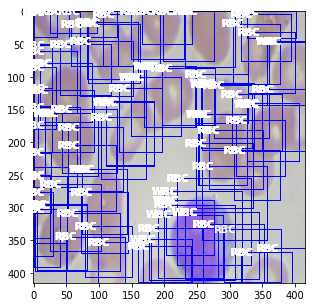

In [40]:
print("Without NMS")
plot_img_bbox(torch_to_pil(im),prediction["boxes"],prediction["labels"])

In [29]:
def nms(prediction,iou_thresh):
  best_box = len(prediction["scores"][prediction["scores"] > iou_thresh].cpu().numpy().tolist())
  bbox = prediction["boxes"][:best_box]
  best_score = prediction["scores"][:best_box]
  best_labels = prediction["labels"][:best_box]
  return bbox,best_score,best_labels

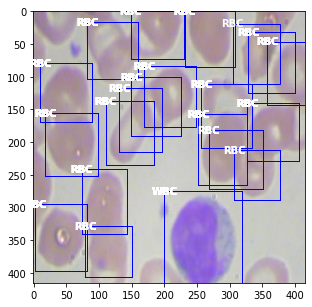

In [41]:
apply_nms = nms(prediction,0.3) #return bbox 
plot_img_bbox(torch_to_pil(im),apply_nms[0],apply_nms[2])
